In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import Sequential
import numpy as np 

# Adapted from content from the following
# https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data
# https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf

train1 = pd.read_csv('train_1.csv', sep=',', header=0)
train2 = pd.read_csv('train_2.csv', sep=',', header=0)
train3 = pd.read_csv('train_3.csv', sep=',', header=0)
train4 = pd.read_csv('train_4.csv', sep=',', header=0)
test = pd.read_csv('test.csv', sep=',', header=0)

train = pd.concat([train1, train2, train3, train4], ignore_index=True)
all_data = pd.concat([train, test], ignore_index=True)[:500]

In [ ]:
#train_layer = keras.layers.Normalization(axis=None).adapt(train)
#test_layer = keras.layers.Normalization(axis=None).adapt(test)
#test_layer
#train_new = train.drop(labels=['date', 'id', 'family'], axis=1)
#data = train_new.values
data = all_data.drop(labels=['date', 'family', 'id', 'store_nbr'], axis=1).values
display(all_data)
data = data.astype('float32')
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.7)
test_size = len(data)-train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(len(train), len(test))

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster 

train1 = pd.read_csv('train_1.csv', sep=',', header=0, parse_dates=['date'])
train2 = pd.read_csv('train_2.csv', sep=',', header=0, parse_dates=['date'])
train3 = pd.read_csv('train_3.csv', sep=',', header=0, parse_dates=['date'])
train4 = pd.read_csv('train_4.csv', sep=',', header=0, parse_dates=['date'])
test = pd.read_csv('test.csv', sep=',', header=0, parse_dates=['date'])

train = pd.concat([train1, train2, train3, train4], ignore_index=True)
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.to_numpy()
df = all_data[:100000]
#f = Forecaster(y = df['sales'], current_dates=df['date'])
f = Forecaster(y = df[:,4], current_dates=df[:,1])
f

Forecaster(
    DateStartActuals=2013-01-01T00:00:00.000000000
    DateEndActuals=2013-02-26T00:00:00.000000000
    Freq=None
    N_actuals=100000
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

c:\Users\talkt\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


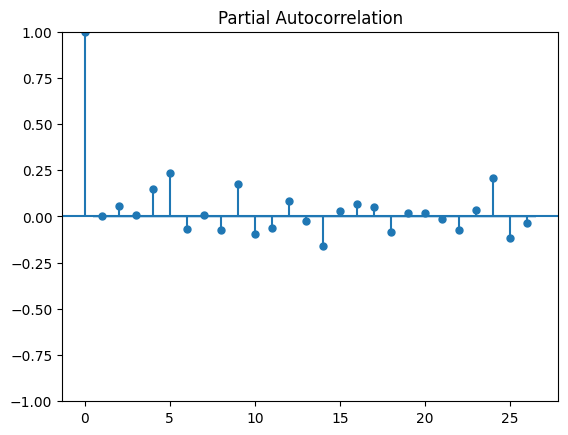

In [35]:
f.plot_pacf(lags=26)
plt.show()

In [36]:
#stat, pval, _, _, _, _ = f.adf_test(full_res=True)

In [37]:
#print(f"Stat: {stat}, Pval: {pval}")

In [38]:
f.set_test_length(12)
f.generate_future_dates(12)
f.set_estimator('lstm')

Epoch 1/2
2499/2499 [==============================] - 13s 5ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 2/2
1/1 [==============================] - 0s 260ms/step
Epoch 1/2
2500/2500 [==============================] - 13s 5ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 2/2
3124/3124 [==============================] - 5s 1ms/step


c:\Users\talkt\AppData\Local\Programs\Python\Python310\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

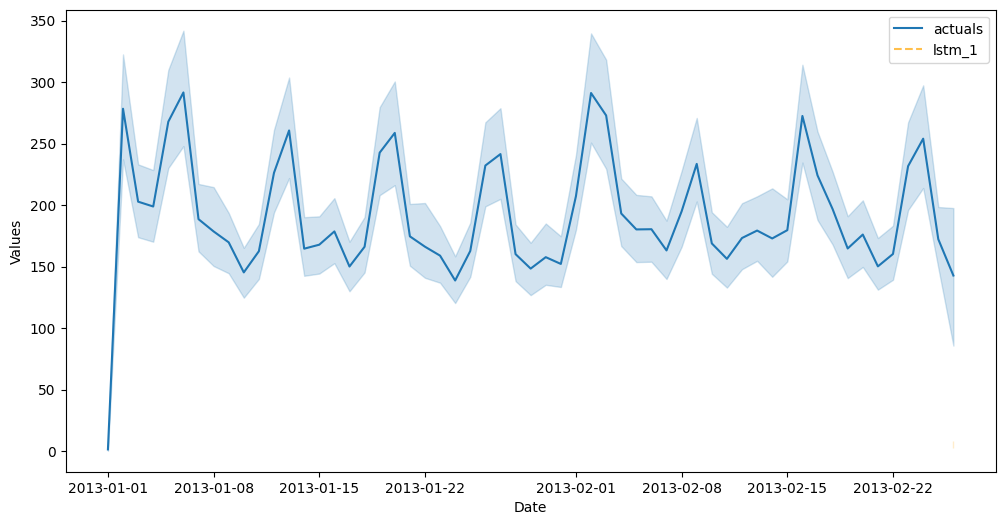

In [39]:
f.manual_forecast(call_me='lstm_1', lags=24, epochs=2, validation_split=.2, shuffle=True)
f.plot_test_set(ci=True)